# Simulate the Tree
This notebook simulates a phylogenetic tree under the dual-birth model [(Moshiri & Mirarab, 2017)](https://doi.org/10.1093/sysbio/syx088) and performs some basic analyses of the tree.

---
**Rule 2: Document Process, Not Just Results.** Here we describe the steps how to produce the dataset.

**Rule 3: Build a Pipeline.** This notebook describes the entire workflow, and its modularity makes it easy to change models or model parameters.

**Rule 7: Share and Explain Your Data.** To enable reproducibility we provide a `/intermediate_data` directory with files produced by the workflow.

---

## Define Tree Simulation Parameters
The dual-birth model is parameterized by two rates: the "birth rate" $\left(\lambda_b\right)$ and the "activation rate" $\left(\lambda_a\right)$, where $\lambda_a\le\lambda_b$. We will start by choosing our desired values for these two rates. For our purposes, we will choose the rate estimates for *Alu* elements as found in the original manuscript [(Moshiri & Mirarab, 2017)](https://doi.org/10.1093/sysbio/syx088).

Our tree simulations also require an end criterion: either a tree height or a number of leaves. We will specify that we want trees with *n* = 100 leaves.

We will also include import statements here to keep the notebook clean and organized.

In [1]:
OUTPUT_TREE_FILE = "./intermediate_data/dualbirth.tre"
BIRTH_RATE = 122.03
ACTIVATION_RATE = 0.73
NUM_LEAVES = 100

In [2]:
import matplotlib.pyplot as plt
from seaborn import distplot
from treesap import dualbirth_tree

## Simulate the Tree
We can now use [TreeSAP](https://github.com/niemasd/TreeSAP) to simulate the tree, which will return a [TreeSwift](https://github.com/niemasd/TreeSwift) `Tree` object.

In [3]:
tree = dualbirth_tree(Lb=BIRTH_RATE, La=ACTIVATION_RATE, end_num_leaves=NUM_LEAVES)

## Explore the Tree
Now that we've simulated our tree, we can begin to explore its properties and statistics. For example, consider the following questions:
* How many lineages exist at any given "time" (where "time" is measured in unit of "expected number of per-site mutations")?
* What is the branch length distribution? What about just internal branches? What about just terminal branches?
* What is the height? Diameter?
* What is the average branch length? Internal branch length? Terminal branch length?
* What is the Colless balance index? Sackin balance index? Gamma statistic? Treeness?

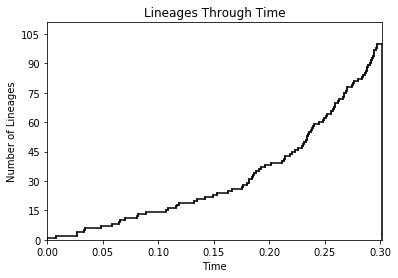

In [4]:
tree.ltt(); plt.show()

In [5]:
branch_lengths = dict()
branch_lengths['all'] = list(tree.branch_lengths())
branch_lengths['internal'] = list(tree.branch_lengths(terminal=False))
branch_lengths['terminal'] = list(tree.branch_lengths(internal=False))

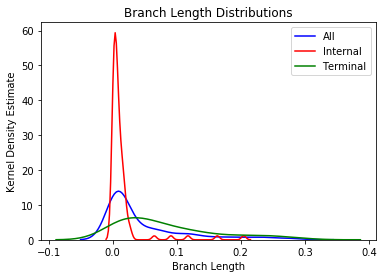

In [6]:
colors = {'all':'blue', 'internal':'red', 'terminal':'green'}
for k in sorted(branch_lengths.keys()):
    distplot(branch_lengths[k], kde=True, hist=False, color=colors[k], label=k.capitalize());
plt.title("Branch Length Distributions");
plt.xlabel("Branch Length");
plt.ylabel("Kernel Density Estimate");

In [7]:
print("Average Branch Length: %f" % tree.avg_branch_length())
print("Average Internal Branch Length: %f" % tree.avg_branch_length(terminal=False))
print("Average Termianl Branch Length: %f" % tree.avg_branch_length(internal=False))
print("Height: %f" % tree.height())
print("Diameter: %f" % tree.diameter())
print("Colless Balance Index: %f" % tree.colless())
print("Sackin Balance Index: %f" % tree.sackin())
print("Gamma Statistic: %f" % tree.gamma_statistic())
print("Treeness: %f" % tree.treeness())

Average Branch Length: 0.048319
Average Internal Branch Length: 0.013666
Average Termianl Branch Length: 0.082624
Height: 0.301767
Diameter: 0.587944
Colless Balance Index: 0.314574
Sackin Balance Index: 18.820000
Gamma Statistic: -7.096932
Treeness: 0.140708


## Save Dataset
Now that we have finished exploring our tree, we can save it in the Newick format. The tool that we wish to use next doesn't support the "rooted" prefix of the Newick format (`[&R]`), so we need to specify to TreeSwift that we wish to omit the "rooted" prefix.

In [8]:
tree.write_tree_newick(OUTPUT_TREE_FILE, hide_rooted_prefix=True)

## Next step
After you saved the dataset here, run the next step in the workflow [2-SimulateSequences.ipynb](./2-SimulateSequences.ipynb) or go back to [0-Workflow.ipynb](./0-Workflow.ipynb).

---

**Author:** [Niema Moshiri](https://niema.net/), UC San Diego, October 2, 2018

---